### Welcome to DATA 602: Introduction to Data Analysis and Machine Learning Spring 2019 Term Project
#### My experiments with word2vec among other things...

We are going to use the following datasets:
* [Amazon Laptop Review Dataset](http://sifaka.cs.uiuc.edu/~wang296/Data/LARA/Amazon/AmazonReviews.zip)

Below, we install and import required libraries

In [1]:
!pip install gensim tensorflow wordcloud
!pip install -q tensorflow-hub
!pip install xgboost
!pip install keras
!pip install nltk
!pip install string
!pip install tqdm

import gzip
import gensim
import os
import sys
import json
import shutil
import time
import re
import tarfile
import zipfile

import numpy as np
import pandas as pd
import collections
import math
import random
import datetime as dt

import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from gensim.test.utils import get_tmpfile
from gensim.models import Word2Vec, FastText

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
import multiprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline


import tensorflow as tf
import tensorflow_hub as hub

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,Dense,Flatten,GlobalMaxPooling1D,LSTM,Dropout, Activation,Bidirectional
from keras.layers.convolutional import Conv1D,MaxPooling1D 
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, precision_recall_curve 
from sklearn import utils

"""
We will ignore FutureWarning and DeprecationWarning
"""
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

"""
We will ignore warnings
"""
warnings.filterwarnings("ignore")

if not sys.warnoptions:
    warnings.simplefilter("ignore")
program_start_time=time.time()

  Could not find a version that satisfies the requirement string (from versions: )
No matching distribution found for string


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
W0506 18:14:10.503599 139801131669312 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14
Using TensorFlow backend.


#### Perform some housekeeping tasks

In [2]:
data_source_url = 'http://sifaka.cs.uiuc.edu/~wang296/Data/LARA/Amazon/AmazonReviews.zip'
datasets = '/datasets/'
data_file_path = os.getcwd()+datasets+'AmazonReviews.zip'
data = 'data_'
AMAZON = 'amazon'
unzip_folder = os.getcwd()+datasets+data+AMAZON
AMAZON_LAPTOPS = 'amazon_laptops'
data_folder = os.getcwd()+datasets+data+AMAZON_LAPTOPS
data_json_file = data+AMAZON_LAPTOPS+'.json'

def check_if_file_exists(file):
    '''
    Checks if 'file' exists
    '''
    try:
        fh = open(file, 'r')
        return True
    except FileNotFoundError:
        print('Please make sure file: ' + file + ' is present before continuing')
        return False

def check_if_dir_exists(directory):
    '''
    Checks if 'directory' exists
    '''
    return(os.path.isdir(directory))

def store_json(write_this_data):
    '''
    Store json if we are processing the first time
    '''
    open(data_json_file, 'w').write(json.dumps(write_this_data))

def return_data_json(json_file):
    '''
    Return data json from data json file
    '''
    with open(json_file, encoding='utf-8') as data_file:
        return json.loads(data_file.read())

**Download data source**

In [3]:
if not check_if_file_exists(data_file_path):
    print('Start of data download')
    wget.download(data_source_url, os.getcwd()+datasets)
    print('Download complete')
else:
    print('Data file already exists. Not downloading again!')

Data file already exists. Not downloading again!


In [4]:
if not check_if_dir_exists(data_folder):
    zip_ref = zipfile.ZipFile(data_file_path, 'r')
    zip_ref.extractall(unzip_folder)
    zip_ref.close()
    try:
        shutil.copytree(unzip_folder+'/laptops/', data_folder)
    except FileExistsError as exc: 
        print('Already copied')
else:
    print('Data foler exists. Won\'t copy again!')

Data foler exists. Won't copy again!


In [5]:
data = {}
all_reviews = []
if not check_if_file_exists(data_json_file):
    for root, dirs, files in os.walk(data_folder):
        for name in files:
            full = os.path.join(root, name)
            json_string = return_data_json(full)
            for review in json_string['Reviews']:
                curr_review = {}
                if float(review['Overall']) <= 2.0:
                    curr_review["rating"] = 0
                else:
                    curr_review["rating"] = 1
                curr_review["review"] = review['Content']
                all_reviews.append(curr_review)
    data[AMAZON_LAPTOPS] = all_reviews
    store_json(data)
pre_loaded_data = return_data_json(data_json_file)
len(pre_loaded_data[AMAZON_LAPTOPS])

40762

**Creating review dataframe and Data clean up**

In [6]:
amazon_df = pd.DataFrame(pre_loaded_data[AMAZON_LAPTOPS])
print('Before Cleanup : Shape of the Data Frame : {}'.format(amazon_df.shape))
print('Remove missing values.')
amazon_df.dropna(inplace=True)
amazon_df.reset_index(drop=True,inplace=True)
print('Drop columns with duplicate data.')
amazon_df.drop_duplicates()
print('After Cleanup : Shape of the Data Frame : {}'.format(amazon_df.shape))
print('Counting null data per column.')
amazon_df.isnull().sum()

Before Cleanup : Shape of the Data Frame : (40762, 2)
Remove missing values.
Drop columns with duplicate data.
After Cleanup : Shape of the Data Frame : (40744, 2)
Counting null data per column.


rating    0
review    0
dtype: int64

* **The dataframe contains 40744 rows and 2 columns**

**Let us look at the data types of columns**

In [7]:
amazon_df.dtypes

rating     int64
review    object
dtype: object

In [8]:
"""
Ratings
"""
amazon_df.rating.unique()

array([1, 0])

**Let us explore the data a bit using head(), tail(), info(), describe()**

In [9]:
amazon_df.head()

,rating,review
0,1,I've had the S7-391 with 4Gb RAM and a 256 GB ...
1,1,This would be a 5-star review if it were not f...
2,1,Exactly as described! Fast laptop. One of the ...
3,1,I bought this laptop after doing my research a...
4,0,"After living with the Aspire S7 for 5 months, ..."


In [10]:
amazon_df.tail()

,rating,review
40739,1,Great to use once you get used to Windows 8 -w...
40740,1,I love this product. It is amazing and it has ...
40741,1,It fast and easy to use win 8 battery very goo...
40742,1,"The computer is a bit light,the outside of the..."
40743,0,Screen failed after 3 months and only limited ...


In [11]:
amazon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40744 entries, 0 to 40743
Data columns (total 2 columns):
rating    40744 non-null int64
review    40744 non-null object
dtypes: int64(1), object(1)
memory usage: 636.7+ KB


In [12]:
amazon_df.describe()

,rating
count,40744.000000
mean,0.807702
std,0.394111
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [13]:
amazon_df.describe(include='object')

,review
count,40744
unique,36471
top,Customers service is a crapI bought this lapto...
freq,11


In [14]:
amazon_df.describe(include='all')

,rating,review
count,40744.000000,40744
unique,NaN,36471
top,NaN,Customers service is a crapI bought this lapto...
freq,NaN,11
mean,0.807702,NaN
std,0.394111,NaN
min,0.000000,NaN
25%,1.000000,NaN
50%,1.000000,NaN
75%,1.000000,NaN


**Creating a new column called "review_length" which is the length of the review column.**

In [15]:
amazon_df['review_length'] = amazon_df['review'].apply(len)
amazon_df.head()

,rating,review,review_length
0,1,I've had the S7-391 with 4Gb RAM and a 256 GB ...,2341
1,1,This would be a 5-star review if it were not f...,1771
2,1,Exactly as described! Fast laptop. One of the ...,166
3,1,I bought this laptop after doing my research a...,919
4,0,"After living with the Aspire S7 for 5 months, ...",1920


#### **Data Visualization and Exploratory Data Analysis**

**Using FacetGrid from the seaborn library to create a grid of two histograms of review_length based off of the ratings**

[FacetGrid reference](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html)

In [16]:
sns.set_style('darkgrid')

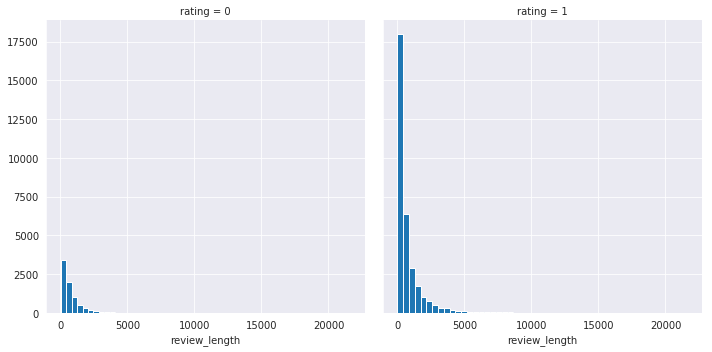

In [17]:
g = sns.FacetGrid(amazon_df,col='rating',size=5)
g.map(plt.hist,'review_length',bins=50)
plt.show()

Let's try to explain why the x-axis goes all the way to 20000ish, this must mean that there is some really long message!

In [18]:
amazon_df.review_length.describe()

count    40744.000000
mean       828.389873
std       1270.138594
min          3.000000
25%        185.000000
50%        407.000000
75%        932.000000
max      21649.000000
Name: review_length, dtype: float64

* Max review_length 21649.000000 means review is 21649 character long

**Creating a boxplot of review_length for each rating category.**

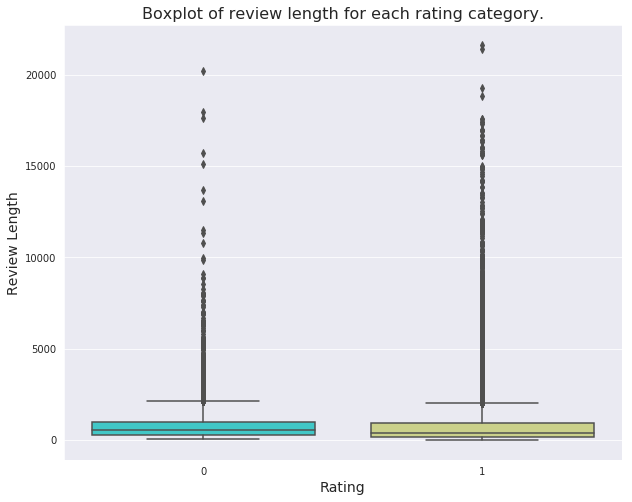

In [19]:
plt.figure(figsize=(10,8))
sns.boxplot(x='rating',y='review_length',data=amazon_df,palette='rainbow')
plt.title("Boxplot of review length for each rating category.",fontsize=16)
plt.xlabel("Rating",fontsize=14)
plt.ylabel("Review Length",fontsize=14)
plt.show()

* Looking at the box and whisker plots for the review_length in words, we can see an exponential distribution. We can observe that the mass of the distribution can possibly be covered with 900 to 1000 words.

**Creating a countplot of the number of occurrences for each type of rating.**

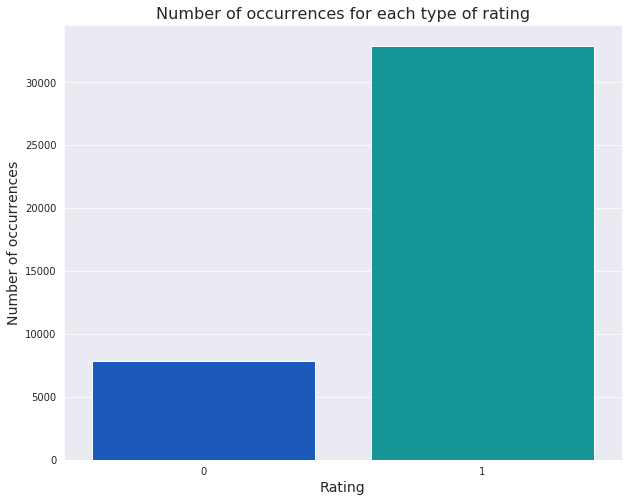

In [20]:
plt.figure(figsize=(10,8))
sns.countplot(x='rating',data=amazon_df,palette='winter')
plt.title("Number of occurrences for each type of rating",fontsize=16)
plt.xlabel("Rating",fontsize=14)
plt.ylabel("Number of occurrences",fontsize=14)
plt.show()

**Pre-processing of review text**

[Regex reference](https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string/9662410)

In [21]:
def review_preprocess(review):
    """
    Takes in a string of review, then performs the following:
    1. Remove HTML tag from review
    2. Remove URLs from review
    3. Make entire review lowercase
    4. Split the review in words
    5. Remove all punctuation
    6. Remove empty strings from review
    7. Remove all stopwords
    8. Returns a list of the cleaned review after jioning them back to a sentence
    """
    en_stops = set(stopwords.words('english'))
    
    """
    Removing HTML tag from review
    """
    clean = re.compile('<.*?>')
    review_without_tag = re.sub(clean, '', review) 
    
    
    """
    Removing URLs
    """
    review_without_tag_and_url = re.sub(r"http\S+", "", review_without_tag)
    
    review_without_tag_and_url = re.sub(r"www\S+", "", review_without_tag)
    
    """
    Make entire string lowercase
    """
    review_lowercase = review_without_tag_and_url.lower()
    
    """
    Split string into words
    """
    list_of_words = word_tokenize(review_lowercase)
    
    
    """
    Remove punctuation
    Checking characters to see if they are in punctuation
    """

    list_of_words_without_punctuation=[''.join(this_char for this_char in this_string if (this_char in string.ascii_lowercase))for this_string in list_of_words]
     
    
    """
    Remove empty strings
    """
    list_of_words_without_punctuation = list(filter(None, list_of_words_without_punctuation))
    
    
    """
    Remove any stopwords
    """
  
    filtered_word_list = [w for w in list_of_words_without_punctuation if w not in en_stops] 
    
    """
    Returns a list of the cleaned review after jioning them back to a sentence
    """
    return ' '.join(filtered_word_list)

In [22]:
"""
Here is the original reviews:
"""
amazon_df['review'].tail()

40739    Great to use once you get used to Windows 8 -w...
40740    I love this product. It is amazing and it has ...
40741    It fast and easy to use win 8 battery very goo...
40742    The computer is a bit light,the outside of the...
40743    Screen failed after 3 months and only limited ...
Name: review, dtype: object

**Applying pre-processing to reviews**

In [23]:
start_time=time.time()
amazon_df['review']=amazon_df['review'].apply(review_preprocess)
print('Elapsed time for review preprocessing : ',((time.time()-start_time)/60),' in minutes')

Elapsed time for review preprocessing :  1.522184415658315  in minutes


In [24]:
"""
Here is the reviews after preprocessing :
"""
amazon_df['review'].tail()

40739    great use get used windows lovevery slickcompu...
40740    love product amazing cool feature like multifu...
40741    fast easy use win battery good feel comf brand...
40742    computer bit light outside computer elegant dr...
40743    screen failed months limited use contacted son...
Name: review, dtype: object

#### The term frequency distribution of words in the review is obtained using nltk.FreqDist(). This provides us a rough idea of the main topic in the review dataset.

[FreqDist reference](http://www.nltk.org/api/nltk.html?highlight=freqdist)

In [25]:
reviews = amazon_df['review'].str.cat(sep=' ')

"""
function to split review into word
"""
tokens = word_tokenize(reviews)

vocabulary = set(tokens)
print('Number of vocabulary : {}'.format(len(vocabulary)))

frequency_distribution = nltk.FreqDist(tokens)
sorted(frequency_distribution,key=frequency_distribution.__getitem__, reverse=True)[0:50]

Number of vocabulary : 84381


['laptop',
 'nt',
 'computer',
 'windows',
 'use',
 'one',
 'screen',
 'like',
 'would',
 'great',
 'get',
 'good',
 'keyboard',
 'battery',
 'really',
 'time',
 'also',
 'work',
 'well',
 'even',
 'drive',
 'much',
 'new',
 'price',
 'fast',
 'machine',
 'used',
 'gb',
 'bought',
 'need',
 'still',
 'buy',
 'could',
 'love',
 'using',
 'first',
 'macbook',
 'back',
 'little',
 'hard',
 'life',
 'got',
 'better',
 'chromebook',
 'nice',
 'problem',
 'apple',
 'works',
 'thing',
 'hp']

#### Wordcloud visualization of frequent words

[Wordcloud reference](https://www.geeksforgeeks.org/generating-word-cloud-python/)

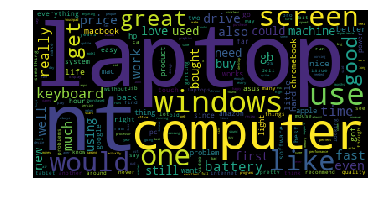

In [26]:
wordcloud = WordCloud().generate_from_frequencies(frequency_distribution)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Train, test split

In [27]:
def split_train_test(x, y):
    SEED = 2000
    x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.2, random_state=SEED)
    x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)
    return x_train, y_train, x_test, y_test, x_validation, y_validation, pd.concat([x_train,x_validation,x_test])

In [28]:
X = amazon_df.review
y = amazon_df.rating
x_train, y_train, x_test, y_test, x_validation, y_validation, all_reviews = split_train_test(X, y)

### We are done pre-processing! Now on to the data analysis and machine learning tasks...

* In the next code cell we reload data if needed or for first time load we simply read data into lists of tokenized items
* Then we train the Word2Vec model

<span style="display:block;text-align:center">![hobbits](hobbits.jpg)

### Concerning embeddings:
* Developed by [Tomas Mikolov in 2013 at Google](https://arxiv.org/pdf/1310.4546.pdf), **Word2Vec** is one of the most popular algorithms to train "word embeddings" using a shallow two layer neural networks having one input layer, one hidden layer and one output layer. There are two models for generating word embeddings, i.e. CBOW and Skip-gram.
* **Word Embedding** is a language modeling technique that uses vectors with several dimensions to represent words from large amounts of unstructured text data. Word embeddings can be generated using various methods like neural networks, co-occurrence matrix, probabilistic models, etc.
* **CBOW (Continuous Bag of Words) model** CBOW model predicts the current word given a context of words. The input layer contains context words and the output layer contains current predicted word. The hidden layer contains the number of dimensions in which we want to represent current word at output layer. The CBOW architecture is shown below ([image credit: Google](https://www.google.com/search?q=cbow&newwindow=1&source=lnms&tbm=isch&sa=X&ved=0ahUKEwibmL_l0YLiAhWoT98KHX8QAisQ_AUIDigB&biw=1855&bih=906))

<span style="display:block;text-align:center">![CBOW](CBOW_ORIGINAL.png)

* **Skip-gram model** flips CBOW's network architecture and aims to predict context given a word. Given current word, Skip gram predicts the surrounding context words. Input layer for it contains the current word and output layer provides the context words. The hidden layer consists of number of dimensions in which we want to represent current input word.The skip-gram architecture is shown below ([image credit: Google](https://www.google.com/search?q=skip+gram&newwindow=1&source=lnms&tbm=isch&sa=X&ved=0ahUKEwjSirSW0oLiAhUOd98KHbbgA5EQ_AUIDygC&biw=1855&bih=952))

<span style="display:block;text-align:center">![SG](skip.png)

* For our Word2Vec modeling we have used CBOW as it is faster and have better representation for more frequent words.

[Word2Vec reference](https://radimrehurek.com/gensim/models/word2vec.html)

**Reload previously processed model if exists**

In [29]:
list_of_tokenized_reviews = []
skip_modeling = False

filename_to_save_model = AMAZON_LAPTOPS + ".model"
if check_if_file_exists(filename_to_save_model):
    skip_modeling = True

In [30]:
if not skip_modeling:
    for one_sentence in all_reviews:
        list_of_tokenized_reviews.append(gensim.utils.simple_preprocess(one_sentence))
    model = Word2Vec(list_of_tokenized_reviews, size=150, window=10, min_count=2, workers=10)
    model.save(filename_to_save_model)
    model = Word2Vec.load(filename_to_save_model)
else:
    model = Word2Vec.load(filename_to_save_model)

W0506 18:16:04.071289 139801131669312 smart_open_lib.py:385] this function is deprecated, use smart_open.open instead


#### Let's look at some output

In [31]:
"""
look up top 10 words similar to the word 'terrible'.
"""
w1 = "terrible"
model.wv.most_similar(positive=w1)

[('horrible', 0.863848865032196),
 ('awful', 0.8366063833236694),
 ('poor', 0.6874389052391052),
 ('crappy', 0.6861168146133423),
 ('bad', 0.680998682975769),
 ('suck', 0.6512565016746521),
 ('sucks', 0.6458801031112671),
 ('subpar', 0.6320646405220032),
 ('worst', 0.6144826412200928),
 ('stupid', 0.5905051231384277)]

In [32]:
"""
look up top 10 words similar to 'excellent'
"""
w1 = ["excellent"]
model.wv.most_similar (positive=w1)

[('fantastic', 0.7522412538528442),
 ('outstanding', 0.7373641133308411),
 ('superb', 0.7291960716247559),
 ('terrific', 0.7222232818603516),
 ('wonderful', 0.6978937983512878),
 ('great', 0.695469856262207),
 ('exceptional', 0.646528422832489),
 ('incredible', 0.6273177862167358),
 ('fabulous', 0.6217853426933289),
 ('good', 0.6088477373123169)]

In [33]:
"""
look up top 8 words similar to 'mac'
"""
w1 = ["mac"]
model.wv.most_similar (positive=w1,topn=8)

[('macs', 0.6919459700584412),
 ('imac', 0.5886913537979126),
 ('apple', 0.5822550654411316),
 ('osx', 0.5632225275039673),
 ('snow', 0.5617016553878784),
 ('apples', 0.5597377419471741),
 ('pcs', 0.5570902228355408),
 ('macintosh', 0.5568829774856567)]

In [34]:
"""
look up top 5 words similar to 'issue'
"""
w1 = ["issue"]
model.wv.most_similar (positive=w1,topn=5)

[('problem', 0.9046769738197327),
 ('issues', 0.750947117805481),
 ('problems', 0.6805667877197266),
 ('bug', 0.678601086139679),
 ('glitch', 0.6227734684944153)]

In [35]:
"""
similarity between two different words
"""
model.wv.similarity(w1="great",w2="worse")

-0.13857192

In [36]:
"""
similarity between two identical words
"""
model.wv.similarity(w1="outstanding",w2="outstanding")

1.0

In [37]:
"""
similarity between two related words
"""
model.wv.similarity(w1="excellent",w2="outstanding")

0.73736417

In [38]:
"""
Which one is the odd one out in this list?
"""
model.wv.doesnt_match(["best","great","good","disapointed"])

'disapointed'

In [39]:
"""
Which one is the odd one out in this list?
"""
model.wv.doesnt_match(["mac","ipad","mackbook","wire"])

'wire'

* **Using dimensionality reduction algorithms like PCA and t-SNE to convert multi-dimensional word vectors to two dimensional plots**
* The goal is to plot our 150 dimensions vectors into 2 dimensional graphs, and check if we can spot interesting patterns.
* Using PCA and t-SNE implementation from scikit-learn for dimension reductions.
* In the visualizations we will look at query word (in **blue**), and most similar words (in **green**), and list of words passed in the function (in **red**).

In [40]:
def word_vectors_plot(model, input_word, word_list):
    """ 
    Seaborn plot results of query word and most similar words, alongwith other words in corpus
    """
    word_arrays = np.empty((0, 150), dtype='f')
    word_tags = [input_word]
    color_list  = ['blue']

    """
    Creating Vector of query word
    """
    word_arrays = np.append(word_arrays, model.wv.__getitem__([input_word]), axis=0)
    
    """
    Find similar words
    """
    similar_words = model.wv.most_similar([input_word],topn=8)
    
    """
    Insert word vector for similar words into array
    """
    for word_score in similar_words:
        word_vector = model.wv.__getitem__([word_score[0]])
        word_tags.append(word_score[0])
        color_list.append('green')
        word_arrays = np.append(word_arrays, word_vector, axis=0)
    
    """
    Insert word vectors for other words into array
    """
    for word in word_list:
        word_vector = model.wv.__getitem__([word])
        word_tags.append(word)
        color_list.append('red')
        word_arrays = np.append(word_arrays, word_vector, axis=0)
        
    """
    Dimensionality from 150 to 17 dimensions with PCA
    """
    reduce = PCA(n_components=17).fit_transform(word_arrays)
    
    
    """
    Finds t-SNE coordinates for 2 dimensions
    """
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduce)
    
    
    """
    Sets everything up to plot
    """
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_tags,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    
    """
    Original plot
    """
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    
    """
    Annotating word in plots
    """
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE viz for input: {}'.format(input_word.title()),fontsize=16)

#### Eight Most Similar Words Vs. Eight Random Words

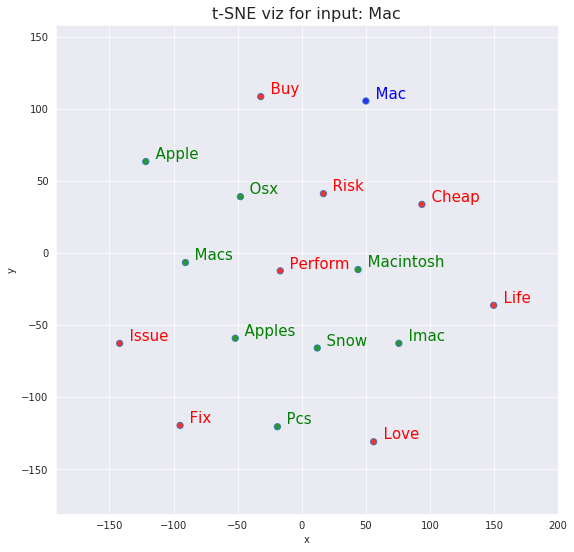

In [41]:
word_vectors_plot(model, 'mac', ['cheap', 'perform', 'risk', 'life', 'issue', 'fix', 'buy', 'love'])

#### Eight Most Similar Words Vs. Ninth To Sixteenth Most Similar Words

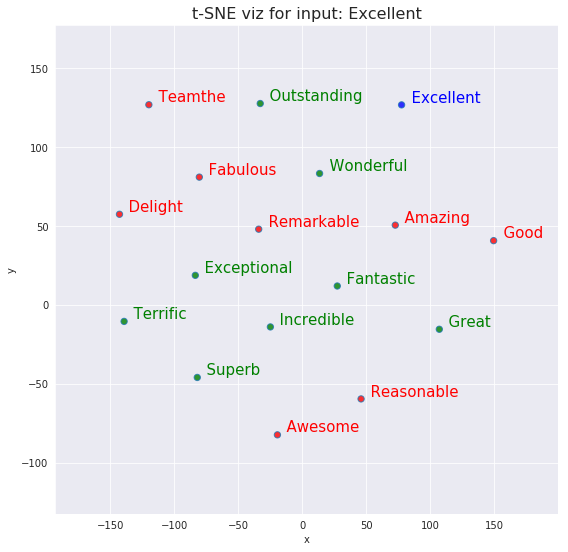

In [42]:
word_vectors_plot(model, "excellent", [t[0] for t in model.wv.most_similar(positive=["excellent"], 
                                                                             topn=16)][8:])

#### Eight Most Similar Words Vs. Ninth To Sixteenth Most Similar Words

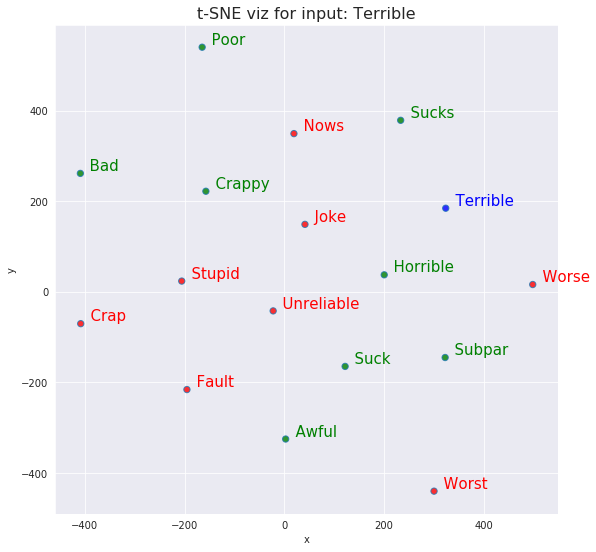

In [43]:
word_vectors_plot(model, "terrible", [t[0] for t in model.wv.most_similar(positive=["terrible"], 
                                                                             topn=16)][8:])

#### Eight Most Similar Words Vs. Ninth To Sixteenth Most Similar Words

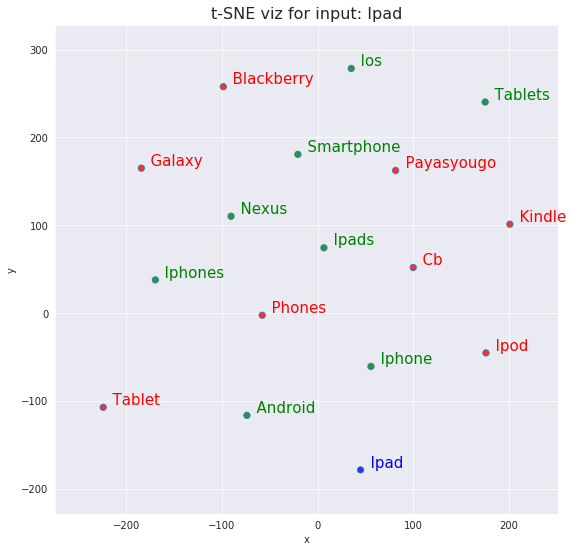

In [44]:
word_vectors_plot(model, "ipad", [t[0] for t in model.wv.most_similar(positive=["ipad"], 
                                                                             topn=16)][8:])

#### Wordcloud visualization of positive words in reviews

In [45]:
pos_lst=[t[0] for t in model.wv.most_similar(positive=["outstanding"],topn=20)]
pos_wrd=' '.join(pos_lst)
print(pos_wrd)

superb fantastic exceptional incredible excellent fabulous remarkable terrific impressive terms delivers aesthetic stellar aesthetics delight phenomenal soundcons superior wonderful amazing


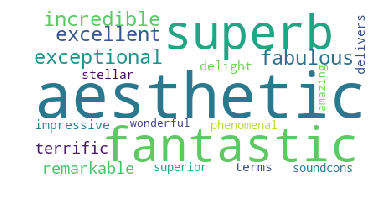

In [46]:
wordcloud = WordCloud(background_color='white',
                      max_words=200000,
                      max_font_size=400).generate(pos_wrd)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Wordcloud visualization of negative words in reviews

In [47]:
neg_lst=[n[0] for n in model.wv.most_similar(positive=["awful"],topn=20)]
neg_wrd=' '.join(neg_lst)
print(neg_wrd)

terrible horrible subpar worse suck oversensitive frustrating sucks weird quirky crappy crackling beeping stupid unreliable hears nows worst unresponsive unusable


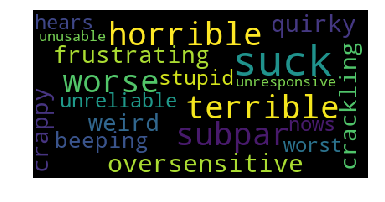

In [48]:
wordcloud = WordCloud(background_color='black',
                      max_words=100,
                      max_font_size=50).generate(neg_wrd)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### **Generating Feature vectors**

In [49]:
"""
Function to generate feature vectors
"""

def generate_feature_vectors(doc, model):
    vec = np.zeros(150).reshape((1, 150))  
    count = 0
    for word in gensim.utils.simple_preprocess(doc):
        if model.__contains__(word.strip()):
            count = count + 1
            vec += model[word.strip()]
    vec = vec / count
    return vec

def generate_features(model, data):
    features = np.concatenate([generate_feature_vectors(s, model) for s in data])
    return features

"""
Generating train, test and validation vectors
"""

training_vectors = generate_features(model, x_train)
test_vectors = generate_features(model, x_test)
validation_vectors = generate_features(model, x_validation)

####  Word2Vec Word Embedding Based Sentiment Analysis using LogisticRegression

In [50]:
lr = LogisticRegression()
lr.fit(training_vectors, y_train)
print("***** Word2Vec Word Embedding Based Sentiment Analysis using LogisticRegression *******\n")
print("LogisticRegression Performance : \n")
print('Train-Set Score : {:.4f}'.format(lr.score(training_vectors, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,lr.predict(training_vectors))))

print("\nEvaluation on Validation-Set : ")
pred_val = lr.predict(validation_vectors)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(lr.score(validation_vectors, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = lr.predict(test_vectors)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(lr.score(test_vectors, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

***** Word2Vec Word Embedding Based Sentiment Analysis using LogisticRegression *******

LogisticRegression Performance : 

Train-Set Score : 0.9046
Train-Set Accuracy : 0.9046

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.69      0.73       762
           1       0.93      0.96      0.94      3312

   micro avg       0.91      0.91      0.91      4074
   macro avg       0.86      0.82      0.84      4074
weighted avg       0.90      0.91      0.90      4074

Confusion matrix:
 [[ 525  237]
 [ 146 3166]]
Validation-Set Score : 0.9060
Validation-Set Accuracy:0.9060

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.67      0.73       833
           1       0.92      0.96      0.94      3242

   micro avg       0.90      0.90      0.90      4075
   macro avg       0.87      0.81      0.84      4075
weighted 

####  Word2Vec Word Embedding Based Sentiment Analysis using SVC

In [51]:
svm = SVC(kernel='linear')
svm.fit(training_vectors, y_train)
print("***** Word2Vec Word Embedding Based Sentiment Analysis using SVC *******\n")
print("SVC with linear kernel Performance : \n")
print('Train-Set Score : {:.4f}'.format(svm.score(training_vectors, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,svm.predict(training_vectors))))

print("\nEvaluation on Validation-Set : ")
pred_val = svm.predict(validation_vectors)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(svm.score(validation_vectors, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = svm.predict(test_vectors)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(svm.score(test_vectors, y_test)))
print("Test-Set Accuracy: {:.4f}".format(accuracy_score(y_test, pred)))

***** Word2Vec Word Embedding Based Sentiment Analysis using SVC *******

SVC with linear kernel Performance : 

Train-Set Score : 0.9050
Train-Set Accuracy : 0.9050

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.79      0.70      0.74       762
           1       0.93      0.96      0.94      3312

   micro avg       0.91      0.91      0.91      4074
   macro avg       0.86      0.83      0.84      4074
weighted avg       0.91      0.91      0.91      4074

Confusion matrix:
 [[ 533  229]
 [ 142 3170]]
Validation-Set Score : 0.9089
Validation-Set Accuracy:0.9089

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.81      0.67      0.73       833
           1       0.92      0.96      0.94      3242

   micro avg       0.90      0.90      0.90      4075
   macro avg       0.86      0.81      0.84      4075
weighted avg       0

#### Word2Vec Word Embedding Based Sentiment Analysis using XGBClassifier

In [52]:
xgb = XGBClassifier()
xgb.fit(training_vectors, y_train)
print("***** Word2Vec Word Embedding Based Sentiment Analysis using XGBClassifier *******\n")
print("XGBClassifier Performance : \n")
print('Train-Set Score : {:.4f}'.format(xgb.score(training_vectors, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,xgb.predict(training_vectors))))

print("\nEvaluation on Validation-Set : ")
pred_val = xgb.predict(validation_vectors)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(xgb.score(validation_vectors, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))


print("\nEvaluation on Test-Set : ")
pred = xgb.predict(test_vectors)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print("Test-Set Score : {:.4f}".format(xgb.score(test_vectors, y_test)))
print("Test-Set Accuracy: {:.4f}".format(accuracy_score(y_test, pred)))

***** Word2Vec Word Embedding Based Sentiment Analysis using XGBClassifier *******

XGBClassifier Performance : 

Train-Set Score : 0.9058
Train-Set Accuracy : 0.9058

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.79      0.68      0.73       762
           1       0.93      0.96      0.94      3312

   micro avg       0.91      0.91      0.91      4074
   macro avg       0.86      0.82      0.84      4074
weighted avg       0.90      0.91      0.90      4074

Confusion matrix:
 [[ 515  247]
 [ 137 3175]]
Validation-Set Score : 0.9057
Validation-Set Accuracy:0.9057

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.81      0.64      0.72       833
           1       0.91      0.96      0.94      3242

   micro avg       0.90      0.90      0.90      4075
   macro avg       0.86      0.80      0.83      4075
weighted avg       

#### Sentiment Analysis using Keras Convolutional Neural Networks(CNN) 
[Keras reference](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)

In [53]:
"""
Create the tokenizer
"""
number_of_words=len(vocabulary)
tokenizer = Tokenizer(num_words=number_of_words)

"""
Fit the tokenizer
"""
tokenizer.fit_on_texts(x_train)

"""
Sequence encode
"""
X_token_train = tokenizer.texts_to_sequences(x_train)
X_token_test = tokenizer.texts_to_sequences(x_test)
X_token_validation = tokenizer.texts_to_sequences(x_validation)

"""
Adding 1 because of reserved 0 index
"""
vocabulary_size = len(tokenizer.word_index) + 1  

print("x_train[2] : ",x_train[2])
print("\n X_token_train[2] : ",X_token_train[2])
print("\n vocab_size : ",vocabulary_size)

x_train[2] :  exactly described fast laptop one slimmest around extremely fast practical super great quality screen high resolution highly recommend

 X_token_train[2] :  [206, 114, 72, 269, 1, 58, 36, 58, 325, 253, 477, 98, 91, 320, 4010, 1674, 1579, 4140, 1363, 260, 831, 178, 3884, 165, 91, 123, 33, 220, 282, 180, 326, 16181, 477, 172, 2, 238, 165, 355, 11280, 513, 14, 41, 122, 13, 6, 1986, 122, 268, 10, 386, 310, 1, 753, 238, 477, 31, 1078, 94, 8, 1, 391, 122, 1078, 10, 6, 126, 593, 486, 130, 945, 6, 546, 30391, 86, 2315, 93, 5701, 922, 20420, 30392, 610, 5831, 58, 188, 198, 2, 87, 130, 1835, 366, 73, 2, 566, 162, 20, 9255, 513, 73, 129, 844, 195, 213, 2315, 585, 20420, 1409, 12356, 30393, 5107, 1472, 268, 4439, 31, 113, 996, 76, 1, 129, 346, 137]

 vocab_size :  73915


In [54]:
"""
Checking the index of each word by looking at the word_index dictionary of the Tokenizer object
"""
for word in ['device','described','laptop', 'resolution', 'highly']:
    print('{} : {}'.format(word, tokenizer.word_index[word]))

device : 142
described : 1354
laptop : 1
resolution : 258
highly : 346


In [55]:
"""
Pad sequences
"""
max_length = 1000

X_token_train = pad_sequences(X_token_train, padding='post', maxlen=max_length)
X_token_test = pad_sequences(X_token_test, padding='post', maxlen=max_length)
X_token_validation = pad_sequences(X_token_validation, padding='post', maxlen=max_length)

In [56]:
%%time
"""
Create model
"""
embedding_dimension = 100

keras_cnn_model = Sequential()
keras_cnn_model.add(Embedding(input_dim=vocabulary_size, 
                              output_dim=embedding_dimension, 
                              input_length=max_length))
keras_cnn_model.add(Conv1D(128, 5, activation='relu'))
keras_cnn_model.add(GlobalMaxPooling1D())
keras_cnn_model.add(Dense(10, activation='relu'))
keras_cnn_model.add(Dense(1, activation='sigmoid'))

"""
Compile network
"""
keras_cnn_model.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
keras_cnn_model.summary()

Instructions for updating:
Colocations handled automatically by placer.


W0506 18:21:23.356515 139801131669312 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         7391500   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 7,456,929
Trainable params: 7,456,929
Non-trainable params: 0
_________________________________________________________________
CPU times: user 140 ms, sys: 0 ns, total: 140 ms
Wall time: 142 ms


In [57]:
%%time
"""
Fit network
"""
keras_cnn_model.fit(X_token_train, y_train,
                    epochs=5,
                    verbose=False,
                    validation_data=(X_token_validation, y_validation),
                    batch_size=10)

"""
Evaluate
"""
print("\n **** Sentiment Analysis Using Keras Convolutional Neural Networks(CNN) ****\n")
loss, accuracy = keras_cnn_model.evaluate(X_token_train, y_train, verbose=False)
print("Train-Set Accuracy: {:.4f}".format(accuracy))


print("\nEvaluation on Validation-Set : ")
pred_val=keras_cnn_model.predict_classes(X_token_validation)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
loss, accuracy = keras_cnn_model.evaluate(X_token_validation, y_validation, verbose=False)
print("Validation-Set Accuracy: {:.4f}".format(accuracy))

print("\nEvaluation on Test-Set : ")
pred=keras_cnn_model.predict_classes(X_token_test)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
loss, accuracy = keras_cnn_model.evaluate(X_token_test, y_test, verbose=False)
print("Test-Set Accuracy:  {:.4f}".format(accuracy))

Instructions for updating:
Use tf.cast instead.


W0506 18:21:23.534948 139801131669312 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0506 18:21:23.680222 139801131669312 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.



 **** Sentiment Analysis Using Keras Convolutional Neural Networks(CNN) ****

Train-Set Accuracy: 0.9992

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.84      0.74      0.78       762
           1       0.94      0.97      0.95      3312

   micro avg       0.92      0.92      0.92      4074
   macro avg       0.89      0.85      0.87      4074
weighted avg       0.92      0.92      0.92      4074

Confusion matrix:
 [[ 561  201]
 [ 109 3203]]
Validation-Set Accuracy: 0.9239

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.71      0.77       833
           1       0.93      0.97      0.95      3242

   micro avg       0.91      0.91      0.91      4075
   macro avg       0.89      0.84      0.86      4075
weighted avg       0.91      0.91      0.91      4075

Confusion matrix:
 [[ 591  242]
 [ 106 3136]]
Test-Set

#### Sentiment Analysis Using Pre-trained Word2Vec Word Embedding To Keras CNN

In [58]:
"""
Vocabulary size
"""
num_of_words = list(model.wv.vocab)
print('Vocabulary size : %d' % len(num_of_words))

Vocabulary size : 33606


In [59]:
%%time
"""
Save model in ASCII
"""
file_name = 'amazon_embedding_word2vec.txt'
model.wv.save_word2vec_format(file_name, binary=False)

W0506 18:55:19.554864 139801131669312 smart_open_lib.py:385] this function is deprecated, use smart_open.open instead


CPU times: user 6.86 s, sys: 124 ms, total: 6.98 s
Wall time: 6.97 s


In [60]:
"""
Load word embedding
"""
def load_word_embedding(file_name):
    word_embedding = dict()
    file = open(file_name,'r')
    lines = file.readlines()[1:]
    file.close()
    
    """
    Mapping words to vectors
    """
    for line in lines:
        line_parts = line.split()
        word_embedding[line_parts[0]] = np.asarray(line_parts[1:], dtype='float32')
        
    return word_embedding

In [61]:
"""
Create a weight matrix for the Embedding layer
"""
def get_embedding_weight_matrix(wrd_embedding, vocabulary):
    
    vocabulary_size = len(vocabulary) + 1
    """
    Define weight matrix dimensions with all 0
    """
    embedding_weight_matrix = np.zeros((vocabulary_size, 150))
    """
    Step vocab, store vectors using the Tokenizer's integer mapping
    """
    for wrd, i in vocabulary.items():
        vector = wrd_embedding.get(wrd)
        if vector is not None:
            embedding_weight_matrix[i] = vector
    return embedding_weight_matrix

In [62]:
"""
Load embedding from file
"""
raw_w2v_embedding = load_word_embedding('amazon_embedding_word2vec.txt')

print('Completed creation of raw word2vec word embedding')

"""
Get weight vectors in the right order
"""
embedding_weight_vectors = get_embedding_weight_matrix(raw_w2v_embedding, tokenizer.word_index)

print('Completed creation of embedding weight vectors')

Completed creation of raw word2vec word embedding
Completed creation of embedding weight vectors


In [63]:
"""
Create the embedding layer
"""
embedding_layer = Embedding(vocabulary_size, 
                            150, 
                            weights=[embedding_weight_vectors], 
                            input_length=max_length, 
                            trainable=False)

print('Completed creation of embedding layer')

Completed creation of embedding layer


In [64]:
"""
Create model
"""
keras_cnn_w2v_model = Sequential()
keras_cnn_w2v_model.add(embedding_layer)
keras_cnn_w2v_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
keras_cnn_w2v_model.add(MaxPooling1D(pool_size=2))
keras_cnn_w2v_model.add(Flatten())
keras_cnn_w2v_model.add(Dense(1, activation='sigmoid'))
keras_cnn_w2v_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 150)         11087250  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 996, 128)          96128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 498, 128)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 63744)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 63745     
Total params: 11,247,123
Trainable params: 159,873
Non-trainable params: 11,087,250
_________________________________________________________________


In [65]:
"""
Compile network
"""
keras_cnn_w2v_model.compile(loss='binary_crossentropy', 
                            optimizer='adam', 
                            metrics=['accuracy'])

"""
Fit network
"""
keras_cnn_w2v_model.fit(X_token_train, y_train,
                        epochs=5,
                        verbose=False,
                        validation_data=(X_token_validation, y_validation),
                        batch_size=10)

"""
Evaluate
"""
print("\n **** Sentiment Analysis Using Pre-trained Word2Vec Word Embedding To Keras CNN ****\n")
loss, accuracy = keras_cnn_w2v_model.evaluate(X_token_train, y_train, verbose=False)
print("Train-Set Accuracy: {:.4f}".format(accuracy))


print("\nEvaluation on Validation-Set : ")
pred_val=keras_cnn_w2v_model.predict_classes(X_token_validation)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
loss, accuracy = keras_cnn_w2v_model.evaluate(X_token_validation, y_validation, verbose=False)
print("Validation-Set Accuracy: {:.4f}".format(accuracy))

print("\nEvaluation on Test-Set : ")
pred=keras_cnn_w2v_model.predict_classes(X_token_test)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
loss, accuracy = keras_cnn_w2v_model.evaluate(X_token_test, y_test, verbose=False)
print("Test-Set Accuracy:  {:.4f}".format(accuracy))


 **** Sentiment Analysis Using Pre-trained Word2Vec Word Embedding To Keras CNN ****

Train-Set Accuracy: 0.9690

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.73      0.71      0.72       762
           1       0.93      0.94      0.94      3312

   micro avg       0.90      0.90      0.90      4074
   macro avg       0.83      0.83      0.83      4074
weighted avg       0.90      0.90      0.90      4074

Confusion matrix:
 [[ 543  219]
 [ 201 3111]]
Validation-Set Accuracy: 0.8969

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.75      0.69      0.72       833
           1       0.92      0.94      0.93      3242

   micro avg       0.89      0.89      0.89      4075
   macro avg       0.84      0.81      0.82      4075
weighted avg       0.89      0.89      0.89      4075

Confusion matrix:
 [[ 571  262]
 [ 190 3052]]


#### Sentiment Analysis  Using Pre-trained Word2Vec Word Embedding To Keras CNN And Bidirectional LSTM

In [66]:
%%time
"""
Create model
"""
keras_cnn_bidir_lstm_w2v_model = Sequential()
keras_cnn_bidir_lstm_w2v_model.add(Embedding(vocabulary_size, 
                                             150, 
                                             weights=[embedding_weight_vectors],
                                             input_length=max_length,  
                                             trainable=False))
keras_cnn_bidir_lstm_w2v_model.add(Conv1D(128, 5, activation='relu'))
keras_cnn_bidir_lstm_w2v_model.add(MaxPooling1D(pool_size=2))
keras_cnn_bidir_lstm_w2v_model.add(Bidirectional(LSTM(64)))
keras_cnn_bidir_lstm_w2v_model.add(Dropout(0.5))
keras_cnn_bidir_lstm_w2v_model.add(Dense(1, activation='sigmoid'))

"""
Compile network
"""
keras_cnn_bidir_lstm_w2v_model.compile(loss='binary_crossentropy', 
                                       optimizer='adam', 
                                       metrics=['accuracy'])
keras_cnn_bidir_lstm_w2v_model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0506 19:09:25.157642 139801131669312 deprecation.py:506] From /opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 150)         11087250  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 996, 128)          96128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 498, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 11,282,323
Trainable params: 195,073
Non-trainable params: 11,087,250
__________________________________________________________

In [67]:
%%time
"""
Fit train data
"""
keras_cnn_bidir_lstm_w2v_model.fit(X_token_train, y_train,
                                   epochs=5,
                                   verbose=False,
                                   validation_data=(X_token_validation, y_validation),
                                   batch_size=10)

CPU times: user 8h 13min 38s, sys: 40min 46s, total: 8h 54min 24s
Wall time: 1h 17min 17s


In [68]:
"""
Evaluate
"""
print("**** Sentiment Analysis  Using Pre-trained Word2Vec Word Embedding To Keras CNN And Bidirectional LSTM ****\n")
loss, accuracy = keras_cnn_bidir_lstm_w2v_model.evaluate(X_token_train, y_train, verbose=False)
print("Train-Set Accuracy: {:.4f}".format(accuracy))

print("\nEvaluation on Validation-Set : ")
pred_val=keras_cnn_bidir_lstm_w2v_model.predict_classes(X_token_validation)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
loss, accuracy = keras_cnn_bidir_lstm_w2v_model.evaluate(X_token_validation, y_validation, verbose=False)
print("Validation-Set Accuracy: {:.4f}".format(accuracy))

print("\nEvaluation on Test-Set : ")
pred=keras_cnn_bidir_lstm_w2v_model.predict_classes(X_token_test)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
loss, accuracy = keras_cnn_bidir_lstm_w2v_model.evaluate(X_token_test, y_test, verbose=False)
print("Test-Set Accuracy:  {:.4f}".format(accuracy))

**** Sentiment Analysis  Using Pre-trained Word2Vec Word Embedding To Keras CNN And Bidirectional LSTM ****

Train-Set Accuracy: 0.9567

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.81      0.75      0.78       762
           1       0.94      0.96      0.95      3312

   micro avg       0.92      0.92      0.92      4074
   macro avg       0.88      0.86      0.87      4074
weighted avg       0.92      0.92      0.92      4074

Confusion matrix:
 [[ 572  190]
 [ 131 3181]]
Validation-Set Accuracy: 0.9212

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.74      0.78       833
           1       0.93      0.96      0.95      3242

   micro avg       0.91      0.91      0.91      4075
   macro avg       0.88      0.85      0.86      4075
weighted avg       0.91      0.91      0.91      4075

Confusion matrix:
 [[ 61

#### Sentiment Analysis Using Pre-trained Word2Vec Word Embedding To Keras Bidirectional LSTM

In [69]:
"""
Create model
"""

keras_bidir_lstm_w2v_model = Sequential()
keras_bidir_lstm_w2v_model.add(Embedding(vocabulary_size, 
                                         150, 
                                         weights=[embedding_weight_vectors],
                                         input_length=max_length,  
                                         trainable=False))
keras_bidir_lstm_w2v_model.add(Bidirectional(LSTM(64)))
keras_bidir_lstm_w2v_model.add(Dropout(0.5))
keras_bidir_lstm_w2v_model.add(Dense(1, activation='sigmoid'))


"""
Compile network
"""
keras_bidir_lstm_w2v_model.compile(loss='binary_crossentropy', 
                                   optimizer='adam', 
                                   metrics=['accuracy'])
keras_bidir_lstm_w2v_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 150)         11087250  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               110080    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 11,197,459
Trainable params: 110,209
Non-trainable params: 11,087,250
_________________________________________________________________


In [70]:
%%time
"""
Fit train data
"""
keras_bidir_lstm_w2v_model.fit(X_token_train, y_train,
                               epochs=5,
                               verbose=False,
                               validation_data=(X_token_validation, y_validation),
                               batch_size=10)

CPU times: user 12h 40min 42s, sys: 1h 21min 17s, total: 14h 2min
Wall time: 2h 1min 12s


In [71]:
"""
Evaluate
"""
print("**** Sentiment Analysis Using Pre-trained Word2Vec Word Embedding To Keras Bidirectional LSTM ****\n")
loss, accuracy = keras_bidir_lstm_w2v_model.evaluate(X_token_train, y_train, verbose=False)
print("Train-Set Accuracy: {:.4f}".format(accuracy))

print("\nEvaluation on Validation-Set : ")
pred_val=keras_bidir_lstm_w2v_model.predict_classes(X_token_validation)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
loss, accuracy = keras_bidir_lstm_w2v_model.evaluate(X_token_validation, y_validation, verbose=False)
print("Validation-Set Accuracy: {:.4f}".format(accuracy))

print("\nEvaluation on Test-Set : ")
pred=keras_bidir_lstm_w2v_model.predict_classes(X_token_test)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))

loss, accuracy = keras_bidir_lstm_w2v_model.evaluate(X_token_test, y_test, verbose=False)
print("Test-Set Accuracy:  {:.4f}".format(accuracy))

**** Sentiment Analysis Using Pre-trained Word2Vec Word Embedding To Keras Bidirectional LSTM ****

Train-Set Accuracy: 0.9418

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79       762
           1       0.95      0.95      0.95      3312

   micro avg       0.92      0.92      0.92      4074
   macro avg       0.87      0.87      0.87      4074
weighted avg       0.92      0.92      0.92      4074

Confusion matrix:
 [[ 607  155]
 [ 169 3143]]
Validation-Set Accuracy: 0.9205

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.81       833
           1       0.94      0.96      0.95      3242

   micro avg       0.92      0.92      0.92      4075
   macro avg       0.89      0.87      0.88      4075
weighted avg       0.92      0.92      0.92      4075

Confusion matrix:
 [[ 652  181]
 

## About Doc2Vec

* **Doc2Vec** is a generalization of the Word2Vec algorithm and applies at the document level. According to [Mikolov et al. (2014)](https://arxiv.org/pdf/1405.4053.pdf), paragraphs in a document are mapped to a vector representation called paragraph vector. This is then combined with the word vectors by averaging or concatenating to predict the next word in a context. The paragraph vector is just like another word vector but it represents the missing context of the the topic of the paragraph.
* **PV-DM or DM:** is the Doc2Vec model analogous to CBOW in Word2Vec. The document vectors are obtained by training a neural network on the task of inferring a centre word based on context words and a context paragraph. See image below for architecture ([image credit: Google](https://www.google.com/search?newwindow=1&biw=1855&bih=952&tbm=isch&sa=1&ei=vQvOXO-dH8rj_AasiKywBw&q=doc2vec+dm&oq=doc2vec+dm&gs_l=img.3..0i24l3.2275.7633..7995...0.0..0.145.386.4j1......1....1..gws-wiz-img.......0j0i30.DJjU4rFKil8))

<span style="display:block;text-align:center">![DM](dm.png)

* **PV-DBOW or DBOW:** is the Doc2Vec model analogous to Skip-gram in Word2Vec. The document vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the document. See image below for architecture ([image credit: Google](https://www.google.com/search?newwindow=1&biw=1855&bih=952&tbm=isch&sa=1&ei=5QvOXPTaNsmIggfb6JGoAw&q=doc2vec+dbow&oq=doc2vec+dbow&gs_l=img.3..0i24l3.20722.21318..21542...0.0..0.69.203.3......0....1..gws-wiz-img.5MtfgvxyAEI))

<span style="display:block;text-align:center">![DBOW](dbow.png)

Below we will see the usage gensim python library with comaprisons of each of these models and their combinations. That is:
1. **DBOW (Distributed Bag of Words)**
2. **DMC (Distributed Memory Concatenated)**
3. **DMM (Distributed Memory Mean)**
4. **DBOW + DMC**
5. **DBOW + DMM**
    
[Doc2Vec reference](https://radimrehurek.com/gensim/models/doc2vec.html)

In [72]:
"""
Function to labelize the reviews
"""
def labelize_review(reviews,label):
    labelized_review = []
    prefix = label
    for indx, rvw in zip(reviews.index, reviews):
        labelized_review.append(LabeledSentence(rvw.split(), [prefix + '_%s' % indx]))
    return labelized_review

In [73]:
"""
labelize the reviews
"""
all_reviews_d2v = labelize_review(all_reviews, 'all')

#### **Distributed Bag Of Words (DBOW)**

In [74]:
%%time
"""
Create doc2vec DBOW model
"""
dbow_model = Doc2Vec(dm=0, 
                     size=150, 
                     negative=5, 
                     min_count=2, 
                     workers=10, 
                     alpha=0.065, 
                     min_alpha=0.065)

dbow_model.build_vocab([review for review in tqdm(all_reviews_d2v)])

W0506 22:35:11.768792 139801131669312 base_any2vec.py:723] consider setting layer size to a multiple of 4 for greater performance
100%|██████████| 40744/40744 [00:00<00:00, 2390542.65it/s]


CPU times: user 2.81 s, sys: 20 ms, total: 2.83 s
Wall time: 2.83 s


In [75]:
%%time

"""
Train the model
"""

for epoch in range(3):
    dbow_model.train(utils.shuffle([review for review in tqdm(all_reviews_d2v)]), 
                     total_examples=len(all_reviews_d2v), 
                     epochs=1)
    dbow_model.alpha -= 0.002
    dbow_model.min_alpha = dbow_model.alpha

100%|██████████| 40744/40744 [00:00<00:00, 2527849.27it/s]


CPU times: user 26.7 s, sys: 1.09 s, total: 27.8 s
Wall time: 10.8 s


In [76]:
"""
Function to generate vectors from corpus
"""

def generate_vectors(model, corpus, size):
    vectors = np.zeros((len(corpus), size))
    n = 0
    for indx in corpus.index:
        prefix = 'all_' + str(indx)
        vectors[n] = model.docvecs[prefix]
        n += 1
    return vectors

In [77]:
"""
Generating train, test and validation vectors
"""

train_vectors_dbow = generate_vectors(dbow_model, x_train, 150)
test_vectors_dbow = generate_vectors(dbow_model, x_test, 150)
validation_vectors_dbow = generate_vectors(dbow_model, x_validation, 150)

#### Doc2Vec Distributed Bag Of Words(DBOW) Based Sentiment Analysis using LogisticRegression

In [78]:
logreg_dbow = LogisticRegression()
logreg_dbow.fit(train_vectors_dbow, y_train)
print("**** Doc2Vec Distributed Bag Of Words(DBOW) Based Sentiment Analysis using LogisticRegression ****\n")
print("LogisticRegression Performance : \n")
print('Train-Set Score : {:.4f}'.format(logreg_dbow.score(train_vectors_dbow, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,logreg_dbow.predict(train_vectors_dbow))))

print("\nEvaluation on Validation-Set : ")
pred_val = logreg_dbow.predict(validation_vectors_dbow)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(logreg_dbow.score(validation_vectors_dbow, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = logreg_dbow.predict(test_vectors_dbow)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(logreg_dbow.score(test_vectors_dbow, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Doc2Vec Distributed Bag Of Words(DBOW) Based Sentiment Analysis using LogisticRegression ****

LogisticRegression Performance : 

Train-Set Score : 0.8982
Train-Set Accuracy : 0.8982

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.69      0.74       762
           1       0.93      0.96      0.95      3312

   micro avg       0.91      0.91      0.91      4074
   macro avg       0.87      0.82      0.84      4074
weighted avg       0.91      0.91      0.91      4074

Confusion matrix:
 [[ 524  238]
 [ 131 3181]]
Validation-Set Score : 0.9094
Validation-Set Accuracy:0.9094

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.81      0.64      0.71       833
           1       0.91      0.96      0.94      3242

   micro avg       0.90      0.90      0.90      4075
   macro avg       0.86      0.80      0.82      407

#### Doc2Vec Distributed Bag Of Words(DBOW) Based Sentiment Analysis using SVC

In [79]:
svm_dbow = SVC(kernel='linear')
svm_dbow.fit(train_vectors_dbow, y_train)
print("**** Doc2Vec Distributed Bag Of Words(DBOW) Based Sentiment Analysis using SVC ****\n")
print("SVC with linear kernel Performance : \n")
print('Train-Set Score : {:.4f}'.format(svm_dbow.score(train_vectors_dbow, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,svm_dbow.predict(train_vectors_dbow))))

print("\nEvaluation on Validation-Set : ")
pred_val = svm_dbow.predict(validation_vectors_dbow)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(svm_dbow.score(validation_vectors_dbow, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = svm_dbow.predict(test_vectors_dbow)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(svm_dbow.score(test_vectors_dbow, y_test)))
print("Test-Set Accuracy: {:.4f}".format(accuracy_score(y_test, pred)))

**** Doc2Vec Distributed Bag Of Words(DBOW) Based Sentiment Analysis using SVC ****

SVC with linear kernel Performance : 

Train-Set Score : 0.8985
Train-Set Accuracy : 0.8985

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.79      0.68      0.73       762
           1       0.93      0.96      0.94      3312

   micro avg       0.91      0.91      0.91      4074
   macro avg       0.86      0.82      0.84      4074
weighted avg       0.90      0.91      0.90      4074

Confusion matrix:
 [[ 520  242]
 [ 136 3176]]
Validation-Set Score : 0.9072
Validation-Set Accuracy:0.9072

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.64      0.72       833
           1       0.91      0.96      0.94      3242

   micro avg       0.90      0.90      0.90      4075
   macro avg       0.86      0.80      0.83      4075
weighted 

#### Doc2Vec Distributed Bag Of Words(DBOW) Based Sentiment Analysis using XGBClassifier

In [80]:
xgb_dbow = XGBClassifier()
xgb_dbow.fit(train_vectors_dbow, y_train)

print("**** Doc2Vec Distributed Bag Of Words(DBOW) Based Sentiment Analysis using XGBClassifier ****\n")
print("XGBClassifier Performance : \n")
print('Train-Set Score : {:.4f}'.format(xgb_dbow.score(train_vectors_dbow, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,xgb_dbow.predict(train_vectors_dbow))))

print("\nEvaluation on Validation-Set : ")
pred_val = xgb_dbow.predict(validation_vectors_dbow)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(xgb_dbow.score(validation_vectors_dbow, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))


print("\nEvaluation on Test-Set : ")
pred = xgb_dbow.predict(test_vectors_dbow)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print("Test-Set Score : {:.4f}".format(xgb_dbow.score(test_vectors_dbow, y_test)))
print("Test-Set Accuracy: {:.4f}".format(accuracy_score(y_test, pred)))

**** Doc2Vec Distributed Bag Of Words(DBOW) Based Sentiment Analysis using XGBClassifier ****

XGBClassifier Performance : 

Train-Set Score : 0.9008
Train-Set Accuracy : 0.9008

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.60      0.68       762
           1       0.91      0.97      0.94      3312

   micro avg       0.90      0.90      0.90      4074
   macro avg       0.86      0.78      0.81      4074
weighted avg       0.89      0.90      0.89      4074

Confusion matrix:
 [[ 455  307]
 [ 115 3197]]
Validation-Set Score : 0.8964
Validation-Set Accuracy:0.8964

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.56      0.67       833
           1       0.90      0.97      0.93      3242

   micro avg       0.88      0.88      0.88      4075
   macro avg       0.86      0.76      0.80      4075
weighted

#### **Distributed Momory (concatenated)**

In [81]:
%%time
"""
Create Doc2Vec DMC model
"""

dmc_model = Doc2Vec(dm=1, 
                    dm_concat=1, 
                    size=150, 
                    window=10, 
                    negative=5, 
                    min_count=2, 
                    workers=10,
                    alpha=0.065,
                    min_alpha=0.065)

dmc_model.build_vocab([review for review in tqdm(all_reviews_d2v)])

W0506 22:39:05.669103 139801131669312 base_any2vec.py:723] consider setting layer size to a multiple of 4 for greater performance
100%|██████████| 40744/40744 [00:00<00:00, 2501943.11it/s]


CPU times: user 2.49 s, sys: 0 ns, total: 2.49 s
Wall time: 2.49 s


In [82]:
%%time

"""
Train the model
"""

for epoch in range(3):
    dmc_model.train(utils.shuffle([review for review in tqdm(all_reviews_d2v)]), 
                    total_examples=len(all_reviews_d2v), 
                    epochs=1)
    dmc_model.alpha -= 0.002
    dmc_model.min_alpha = dmc_model.alpha

100%|██████████| 40744/40744 [00:00<00:00, 2154309.08it/s]


CPU times: user 3min 49s, sys: 4.36 s, total: 3min 53s
Wall time: 39.1 s


In [83]:
"""
Generating train, test and validation vectors
"""
train_vectors_dmc = generate_vectors(dmc_model, x_train, 150)
test_vectors_dmc = generate_vectors(dmc_model, x_test, 150)
validation_vectors_dmc = generate_vectors(dmc_model, x_validation, 150)

#### Doc2Vec DMC Based Sentiment Analysis using LogisticRegression

In [84]:
logreg_dmc = LogisticRegression()
logreg_dmc.fit(train_vectors_dmc, y_train)
print("**** Doc2Vec Distributed Momory (concatenated) Based Sentiment Analysis using LogisticRegression ****\n")
print("LogisticRegression Performance : \n")
print('Train-Set Score : {:.4f}'.format(logreg_dmc.score(train_vectors_dmc, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,logreg_dmc.predict(train_vectors_dmc))))

print("\nEvaluation on Validation-Set : ")
pred_val = logreg_dmc.predict(validation_vectors_dmc)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(logreg_dmc.score(validation_vectors_dmc, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = logreg_dmc.predict(test_vectors_dmc)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(logreg_dmc.score(test_vectors_dmc, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Doc2Vec Distributed Momory (concatenated) Based Sentiment Analysis using LogisticRegression ****

LogisticRegression Performance : 

Train-Set Score : 0.8088
Train-Set Accuracy : 0.8088

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.01      0.01       762
           1       0.81      1.00      0.90      3312

   micro avg       0.81      0.81      0.81      4074
   macro avg       0.81      0.50      0.45      4074
weighted avg       0.81      0.81      0.73      4074

Confusion matrix:
 [[   4  758]
 [   1 3311]]
Validation-Set Score : 0.8137
Validation-Set Accuracy:0.8137

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       833
           1       0.80      1.00      0.89      3242

   micro avg       0.80      0.80      0.80      4075
   macro avg       0.90      0.50      0.45      

#### Doc2Vec DMC Based Sentiment Analysis using SVC

In [85]:
svm_dmc = SVC(kernel='linear')
svm_dmc.fit(train_vectors_dmc, y_train)

print("**** Doc2Vec Distributed Momory (concatenated) Based Sentiment Analysis using SVC ****\n")
print("SVC with linear kernel Performance : \n")
print('Train-Set Score : {:.4f}'.format(svm_dmc.score(train_vectors_dmc, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,svm_dmc.predict(train_vectors_dmc))))

print("\nEvaluation on Validation-Set : ")
pred_val = svm_dmc.predict(validation_vectors_dmc)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(svm_dmc.score(validation_vectors_dmc, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = svm_dmc.predict(test_vectors_dmc)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(svm_dmc.score(test_vectors_dmc, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Doc2Vec Distributed Momory (concatenated) Based Sentiment Analysis using SVC ****

SVC with linear kernel Performance : 

Train-Set Score : 0.8086
Train-Set Accuracy : 0.8086

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       762
           1       0.81      1.00      0.90      3312

   micro avg       0.81      0.81      0.81      4074
   macro avg       0.41      0.50      0.45      4074
weighted avg       0.66      0.81      0.73      4074

Confusion matrix:
 [[   0  762]
 [   0 3312]]
Validation-Set Score : 0.8130
Validation-Set Accuracy:0.8130

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       833
           1       0.80      1.00      0.89      3242

   micro avg       0.80      0.80      0.80      4075
   macro avg       0.40      0.50      0.44      4075
weight

#### Doc2Vec DMC Based Sentiment Analysis using XGBClassifier

In [86]:
xgb_dmc = XGBClassifier()
xgb_dmc.fit(train_vectors_dmc, y_train)

print("**** Doc2Vec Distributed Momory (concatenated) Based Sentiment Analysis using XGBClassifier ****\n")
print("XGBClassifier Performance : \n")
print('Train-Set Score : {:.4f}'.format(xgb_dmc.score(train_vectors_dmc, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,xgb_dmc.predict(train_vectors_dmc))))

print("\nEvaluation on Validation-Set : ")
pred_val = xgb_dmc.predict(validation_vectors_dmc)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(xgb_dmc.score(validation_vectors_dmc, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = xgb_dmc.predict(test_vectors_dmc)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(xgb_dmc.score(test_vectors_dmc, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Doc2Vec Distributed Momory (concatenated) Based Sentiment Analysis using XGBClassifier ****

XGBClassifier Performance : 

Train-Set Score : 0.8137
Train-Set Accuracy : 0.8137

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.76      0.05      0.09       762
           1       0.82      1.00      0.90      3312

   micro avg       0.82      0.82      0.82      4074
   macro avg       0.79      0.52      0.50      4074
weighted avg       0.81      0.82      0.75      4074

Confusion matrix:
 [[  38  724]
 [  12 3300]]
Validation-Set Score : 0.8193
Validation-Set Accuracy:0.8193

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.61      0.03      0.06       833
           1       0.80      0.99      0.89      3242

   micro avg       0.80      0.80      0.80      4075
   macro avg       0.70      0.51      0.48      4075
weigh

#### Distributed Memory (mean)

In [87]:
%%time
"""
Create doc2vec DMM model
"""
dmm_model = Doc2Vec(dm=1, 
                    dm_mean=1, 
                    size=150, 
                    window=10, 
                    negative=5, 
                    min_count=2, 
                    workers=10, 
                    alpha=0.065, 
                    min_alpha=0.065)

dmm_model.build_vocab([review for review in tqdm(all_reviews_d2v)])

W0506 22:44:19.779132 139801131669312 base_any2vec.py:723] consider setting layer size to a multiple of 4 for greater performance
100%|██████████| 40744/40744 [00:00<00:00, 2511171.03it/s]


CPU times: user 2.52 s, sys: 20 ms, total: 2.54 s
Wall time: 2.53 s


In [88]:
%%time

"""
Train the model
"""

for epoch in range(3):
    dmm_model.train(utils.shuffle([review for review in tqdm(all_reviews_d2v)]), 
                    total_examples=len(all_reviews_d2v), 
                    epochs=1)
    dmm_model.alpha -= 0.002
    dmm_model.min_alpha = dmm_model.alpha

100%|██████████| 40744/40744 [00:00<00:00, 2422017.66it/s]


CPU times: user 41.8 s, sys: 3.66 s, total: 45.4 s
Wall time: 14.3 s


In [89]:
"""
Generating train, test and validation vectors
"""

train_vectors_dmm = generate_vectors(dmm_model, x_train, 150)
test_vectors_dmm = generate_vectors(dmm_model, x_test, 150)
validation_vectors_dmm = generate_vectors(dmm_model, x_validation, 150)

#### Doc2Vec DMM Based Sentiment Analysis using LogisticRegression

In [90]:
logreg_dmm = LogisticRegression()
logreg_dmm.fit(train_vectors_dmm, y_train)
print("**** Doc2Vec Distributed Memory(mean) Based Sentiment Analysis using LogisticRegression ****\n")
print("LogisticRegression Performance : \n")
print('Train-Set Score : {:.4f}'.format(logreg_dmm.score(train_vectors_dmm, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,logreg_dmm.predict(train_vectors_dmm))))

print("\nEvaluation on Validation-Set : ")
pred_val = logreg_dmm.predict(validation_vectors_dmm)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(logreg_dmm.score(validation_vectors_dmm, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = logreg_dmm.predict(test_vectors_dmm)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(logreg_dmm.score(test_vectors_dmm, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Doc2Vec Distributed Memory(mean) Based Sentiment Analysis using LogisticRegression ****

LogisticRegression Performance : 

Train-Set Score : 0.8472
Train-Set Accuracy : 0.8472

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.74      0.36      0.49       762
           1       0.87      0.97      0.92      3312

   micro avg       0.86      0.86      0.86      4074
   macro avg       0.81      0.67      0.70      4074
weighted avg       0.85      0.86      0.84      4074

Confusion matrix:
 [[ 276  486]
 [  96 3216]]
Validation-Set Score : 0.8571
Validation-Set Accuracy:0.8571

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.70      0.30      0.42       833
           1       0.84      0.97      0.90      3242

   micro avg       0.83      0.83      0.83      4075
   macro avg       0.77      0.63      0.66      4075
weig

#### Doc2Vec DMM Based Sentiment Analysis using SVC

In [91]:
svm_dmm = SVC(kernel='linear')
svm_dmm.fit(train_vectors_dmm, y_train)
print("**** Doc2Vec Distributed Memory(mean) Based Sentiment Analysis using SVC ****\n")
print("SVC With Linear Kernel Performance : \n")
print('Train-Set Score : {:.4f}'.format(svm_dmm.score(train_vectors_dmm, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,svm_dmm.predict(train_vectors_dmm))))

print("\nEvaluation on Validation-Set : ")
pred_val = svm_dmm.predict(validation_vectors_dmm)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(svm_dmm.score(validation_vectors_dmm, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = svm_dmm.predict(test_vectors_dmm)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(svm_dmm.score(test_vectors_dmm, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Doc2Vec Distributed Memory(mean) Based Sentiment Analysis using SVC ****

SVC With Linear Kernel Performance : 

Train-Set Score : 0.8428
Train-Set Accuracy : 0.8428

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.30      0.44       762
           1       0.86      0.98      0.92      3312

   micro avg       0.86      0.86      0.86      4074
   macro avg       0.83      0.64      0.68      4074
weighted avg       0.85      0.86      0.83      4074

Confusion matrix:
 [[ 231  531]
 [  58 3254]]
Validation-Set Score : 0.8554
Validation-Set Accuracy:0.8554

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.74      0.24      0.36       833
           1       0.83      0.98      0.90      3242

   micro avg       0.83      0.83      0.83      4075
   macro avg       0.79      0.61      0.63      4075
weighted avg   

#### Doc2Vec DMM Based Sentiment Analysis using XGBClassifier

In [92]:
xgb_dmm = XGBClassifier()
xgb_dmm.fit(train_vectors_dmm, y_train)

print("**** Doc2Vec Distributed Memory(mean) Based Sentiment Analysis using XGBClassifier ****\n")
print("XGBClassifier Performance : \n")
print('Train-Set Score : {:.4f}'.format(xgb_dmm.score(train_vectors_dmm, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,xgb_dmm.predict(train_vectors_dmm))))

print("\nEvaluation on Validation-Set : ")
pred_val = xgb_dmm.predict(validation_vectors_dmm)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(xgb_dmm.score(validation_vectors_dmm, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = xgb_dmm.predict(test_vectors_dmm)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(xgb_dmm.score(test_vectors_dmm, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Doc2Vec Distributed Memory(mean) Based Sentiment Analysis using XGBClassifier ****

XGBClassifier Performance : 

Train-Set Score : 0.8494
Train-Set Accuracy : 0.8494

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.28      0.42       762
           1       0.86      0.98      0.92      3312

   micro avg       0.85      0.85      0.85      4074
   macro avg       0.83      0.63      0.67      4074
weighted avg       0.85      0.85      0.82      4074

Confusion matrix:
 [[ 216  546]
 [  55 3257]]
Validation-Set Score : 0.8525
Validation-Set Accuracy:0.8525

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.76      0.23      0.36       833
           1       0.83      0.98      0.90      3242

   micro avg       0.83      0.83      0.83      4075
   macro avg       0.80      0.61      0.63      4075
weighted avg  

#### Combination of Doc2Vec Distributed Bag Of Words (DBOW) And Distributed Memory(Concatenated)

Now, I have the document vectors from three different models, now I can concatenate them in combination to see how it affects the performance. Below I defined a function to concatenate document vectors from different models

In [93]:
"""
Function to concatenate document vectors from different models
"""

def generate_concat_vectors(model1,model2, corpus, size):
    vectors = np.zeros((len(corpus), size))
    n = 0
    for indx in corpus.index:
        prefix = 'all_' + str(indx)
        vectors[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n += 1
    return vectors

In [94]:
"""
Generating train, test and validation document vectors
"""
train_vectors_dbow_dmc = generate_concat_vectors(dbow_model,dmc_model, x_train, 300)
test_vectors_dbow_dmc = generate_concat_vectors(dbow_model,dmc_model, x_test, 300)
validation_vectors_dbow_dmc = generate_concat_vectors(dbow_model,dmc_model, x_validation, 300)

#### Combination of Doc2Vec DBOW And DMC Based Sentiment Analysis using LogisticRegression

In [95]:
logreg_dbow_dmc = LogisticRegression()
logreg_dbow_dmc.fit(train_vectors_dbow_dmc, y_train)
print("**** Combination of Doc2Vec DBOW And DMC Based Sentiment Analysis using LogisticRegression ****\n")
print("LogisticRegression Performance : \n")
print('Train-Set Score : {:.4f}'.format(logreg_dbow_dmc.score(train_vectors_dbow_dmc, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,logreg_dbow_dmc.predict(train_vectors_dbow_dmc))))

print("\nEvaluation on Validation-Set : ")
pred_val = logreg_dbow_dmc.predict(validation_vectors_dbow_dmc)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(logreg_dbow_dmc.score(validation_vectors_dbow_dmc, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = logreg_dbow_dmc.predict(test_vectors_dbow_dmc)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(logreg_dbow_dmc.score(test_vectors_dbow_dmc, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Combination of Doc2Vec DBOW And DMC Based Sentiment Analysis using LogisticRegression ****

LogisticRegression Performance : 

Train-Set Score : 0.8982
Train-Set Accuracy : 0.8982

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.69      0.74       762
           1       0.93      0.96      0.95      3312

   micro avg       0.91      0.91      0.91      4074
   macro avg       0.87      0.83      0.84      4074
weighted avg       0.91      0.91      0.91      4074

Confusion matrix:
 [[ 526  236]
 [ 131 3181]]
Validation-Set Score : 0.9099
Validation-Set Accuracy:0.9099

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.81      0.63      0.71       833
           1       0.91      0.96      0.94      3242

   micro avg       0.89      0.89      0.89      4075
   macro avg       0.86      0.80      0.82      4075
w

#### Combination of Doc2Vec DBOW And DMC Based Sentiment Analysis using SVC

In [96]:
svm_dbow_dmc = SVC(kernel='linear')
svm_dbow_dmc.fit(train_vectors_dbow_dmc, y_train)
print("**** Combination of Doc2Vec DBOW And DMC Based Sentiment Analysis using SVC ****\n")
print("SVC with linear kernel Performance : \n")
print('Train-Set Score : {:.4f}'.format(svm_dbow_dmc.score(train_vectors_dbow_dmc, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,svm_dbow_dmc.predict(train_vectors_dbow_dmc))))

print("\nEvaluation on Validation-Set : ")
pred_val = svm_dbow_dmc.predict(validation_vectors_dbow_dmc)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(svm_dbow_dmc.score(validation_vectors_dbow_dmc, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = svm_dbow_dmc.predict(test_vectors_dbow_dmc)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(svm_dbow_dmc.score(test_vectors_dbow_dmc, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Combination of Doc2Vec DBOW And DMC Based Sentiment Analysis using SVC ****

SVC with linear kernel Performance : 

Train-Set Score : 0.8990
Train-Set Accuracy : 0.8990

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.79      0.68      0.73       762
           1       0.93      0.96      0.94      3312

   micro avg       0.91      0.91      0.91      4074
   macro avg       0.86      0.82      0.84      4074
weighted avg       0.90      0.91      0.90      4074

Confusion matrix:
 [[ 520  242]
 [ 136 3176]]
Validation-Set Score : 0.9072
Validation-Set Accuracy:0.9072

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.64      0.72       833
           1       0.91      0.97      0.94      3242

   micro avg       0.90      0.90      0.90      4075
   macro avg       0.87      0.80      0.83      4075
weighted avg

#### Combination of Doc2Vec DBOW And DMC Based Sentiment Analysis using XGBClassifier

In [97]:
xgb_dbow_dmc =XGBClassifier()
xgb_dbow_dmc.fit(train_vectors_dbow_dmc, y_train)
print("**** Combination of Doc2Vec DBOW And DMC Based Sentiment Analysis using XGBClassifier ****\n")
print("XGBClassifier Performance : \n")
print('Train-Set Score : {:.4f}'.format(xgb_dbow_dmc.score(train_vectors_dbow_dmc, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,xgb_dbow_dmc.predict(train_vectors_dbow_dmc))))

print("\nEvaluation on Validation-Set : ")
pred_val = xgb_dbow_dmc.predict(validation_vectors_dbow_dmc)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(xgb_dbow_dmc.score(validation_vectors_dbow_dmc, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = xgb_dbow_dmc.predict(test_vectors_dbow_dmc)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(xgb_dbow_dmc.score(test_vectors_dbow_dmc, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Combination of Doc2Vec DBOW And DMC Based Sentiment Analysis using XGBClassifier ****

XGBClassifier Performance : 

Train-Set Score : 0.9000
Train-Set Accuracy : 0.9000

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.60      0.69       762
           1       0.91      0.97      0.94      3312

   micro avg       0.90      0.90      0.90      4074
   macro avg       0.86      0.78      0.81      4074
weighted avg       0.89      0.90      0.89      4074

Confusion matrix:
 [[ 457  305]
 [ 115 3197]]
Validation-Set Score : 0.8969
Validation-Set Accuracy:0.8969

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.81      0.57      0.67       833
           1       0.90      0.97      0.93      3242

   micro avg       0.88      0.88      0.88      4075
   macro avg       0.86      0.77      0.80      4075
weighted av

#### Combination of Doc2Vec Distributed Bag Of Words (DBOW) And Distributed Memory(Mean)

In [98]:
"""
Generating train, test and validation document vectors
"""
train_vectors_dbow_dmm = generate_concat_vectors(dbow_model,dmm_model, x_train, 300)
test_vectors_dbow_dmm = generate_concat_vectors(dbow_model,dmm_model, x_test, 300)
validation_vectors_dbow_dmm = generate_concat_vectors(dbow_model,dmm_model, x_validation, 300)

#### Combination of Doc2Vec DBOW And DMM Based Sentiment Analysis using LogisticRegression

In [99]:
logreg_dbow_dmm = LogisticRegression()
logreg_dbow_dmm.fit(train_vectors_dbow_dmm, y_train)
print("**** Combination of Doc2Vec DBOW And DMM Based Sentiment Analysis using LogisticRegression ****\n")
print("LogisticRegression Performance : \n")
print('Train-Set Score : {:.4f}'.format(logreg_dbow_dmm.score(train_vectors_dbow_dmm, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,logreg_dbow_dmm.predict(train_vectors_dbow_dmm))))

print("\nEvaluation on Validation-Set : ")
pred_val = logreg_dbow_dmm.predict(validation_vectors_dbow_dmm)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(logreg_dbow_dmm.score(validation_vectors_dbow_dmm, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = logreg_dbow_dmm.predict(test_vectors_dbow_dmm)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(logreg_dbow_dmm.score(test_vectors_dbow_dmm, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Combination of Doc2Vec DBOW And DMM Based Sentiment Analysis using LogisticRegression ****

LogisticRegression Performance : 

Train-Set Score : 0.9024
Train-Set Accuracy : 0.9024

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.69      0.74       762
           1       0.93      0.96      0.95      3312

   micro avg       0.91      0.91      0.91      4074
   macro avg       0.87      0.82      0.84      4074
weighted avg       0.91      0.91      0.91      4074

Confusion matrix:
 [[ 522  240]
 [ 130 3182]]
Validation-Set Score : 0.9092
Validation-Set Accuracy:0.9092

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.65      0.72       833
           1       0.91      0.96      0.94      3242

   micro avg       0.90      0.90      0.90      4075
   macro avg       0.87      0.81      0.83      4075
w

#### Combination of Doc2Vec DBOW And DMM Based Sentiment Analysis using SVC

In [100]:
svm_dbow_dmm = SVC(kernel='linear')
svm_dbow_dmm.fit(train_vectors_dbow_dmm, y_train)
print("**** Combination of Doc2Vec DBOW And DMM Based Sentiment Analysis using SVC ****\n")
print("SVC with linear kernel Performance : \n")
print('Train-Set Score : {:.4f}'.format(svm_dbow_dmm.score(train_vectors_dbow_dmm, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,svm_dbow_dmm.predict(train_vectors_dbow_dmm))))

print("\nEvaluation on Validation-Set : ")
pred_val = svm_dbow_dmm.predict(validation_vectors_dbow_dmm)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(svm_dbow_dmm.score(validation_vectors_dbow_dmm, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = svm_dbow_dmm.predict(test_vectors_dbow_dmm)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(svm_dbow_dmm.score(test_vectors_dbow_dmm, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Combination of Doc2Vec DBOW And DMM Based Sentiment Analysis using SVC ****

SVC with linear kernel Performance : 

Train-Set Score : 0.9033
Train-Set Accuracy : 0.9033

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.69      0.74       762
           1       0.93      0.96      0.95      3312

   micro avg       0.91      0.91      0.91      4074
   macro avg       0.86      0.82      0.84      4074
weighted avg       0.91      0.91      0.91      4074

Confusion matrix:
 [[ 523  239]
 [ 131 3181]]
Validation-Set Score : 0.9092
Validation-Set Accuracy:0.9092

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.65      0.73       833
           1       0.91      0.97      0.94      3242

   micro avg       0.90      0.90      0.90      4075
   macro avg       0.87      0.81      0.83      4075
weighted avg

#### Combination of Doc2Vec DBOW And DMM Based Sentiment Analysis using XGBClassifier

In [101]:
xgb_dbow_dmm =XGBClassifier()
xgb_dbow_dmm.fit(train_vectors_dbow_dmm, y_train)
print("**** Combination of Doc2Vec DBOW And DMM Based Sentiment Analysis using XGBClassifier ****\n")
print("XGBClassifier Performance : \n")
print('Train-Set Score : {:.4f}'.format(xgb_dbow_dmm.score(train_vectors_dbow_dmm, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,xgb_dbow_dmm.predict(train_vectors_dbow_dmm))))

print("\nEvaluation on Validation-Set : ")
pred_val = xgb_dbow_dmm.predict(validation_vectors_dbow_dmm)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(xgb_dbow_dmm.score(validation_vectors_dbow_dmm, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = xgb_dbow_dmm.predict(test_vectors_dbow_dmm)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(xgb_dbow_dmm.score(test_vectors_dbow_dmm, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Combination of Doc2Vec DBOW And DMM Based Sentiment Analysis using XGBClassifier ****

XGBClassifier Performance : 

Train-Set Score : 0.9016
Train-Set Accuracy : 0.9016

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.81      0.60      0.69       762
           1       0.91      0.97      0.94      3312

   micro avg       0.90      0.90      0.90      4074
   macro avg       0.86      0.78      0.81      4074
weighted avg       0.89      0.90      0.89      4074

Confusion matrix:
 [[ 457  305]
 [ 108 3204]]
Validation-Set Score : 0.8986
Validation-Set Accuracy:0.8986

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.56      0.67       833
           1       0.90      0.97      0.93      3242

   micro avg       0.89      0.89      0.89      4075
   macro avg       0.86      0.76      0.80      4075
weighted av

#### Sentiment Analysis Using Combination of Doc2Vec DBOW And DMC Document Embedding and Keras Neural Network

In [102]:
"""
Create model
"""
keras_d2v_combo_dbow_dmc_model = Sequential()
keras_d2v_combo_dbow_dmc_model.add(Dense(128, activation='relu', input_dim=300))
keras_d2v_combo_dbow_dmc_model.add(Dense(128, activation='relu'))
keras_d2v_combo_dbow_dmc_model.add(Dense(1, activation='sigmoid'))

"""
Compile network
"""
keras_d2v_combo_dbow_dmc_model.compile(optimizer='adam',
                                       loss='binary_crossentropy',
                                       metrics=['accuracy'])
keras_d2v_combo_dbow_dmc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               38528     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 55,169
Trainable params: 55,169
Non-trainable params: 0
_________________________________________________________________


In [103]:
"""
Fit network
"""
keras_d2v_combo_dbow_dmc_model.fit(train_vectors_dbow_dmc, y_train,
                                   validation_data=(validation_vectors_dbow_dmc, y_validation),
                                   epochs=5, 
                                   batch_size=10, 
                                   verbose=False)

"""
Evaluate
"""
print("**** Sentiment Analysis Using Combination of Doc2Vec DBOW And DMC Document Embedding and Keras Neural Network ****\n")
loss, accuracy = keras_d2v_combo_dbow_dmc_model.evaluate(train_vectors_dbow_dmc, y_train, verbose=False)
print("Train-Set Accuracy: {:.4f}".format(accuracy))

print("\nEvaluation on Validation-Set : ")
pred_val=keras_d2v_combo_dbow_dmc_model.predict_classes(validation_vectors_dbow_dmc)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
loss, accuracy = keras_d2v_combo_dbow_dmc_model.evaluate(validation_vectors_dbow_dmc, y_validation, verbose=False)
print("Validation-Set Accuracy: {:.4f}".format(accuracy))

print("\nEvaluation on Test-Set : ")
pred=keras_d2v_combo_dbow_dmc_model.predict_classes(test_vectors_dbow_dmc)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))

loss, accuracy = keras_d2v_combo_dbow_dmc_model.evaluate(test_vectors_dbow_dmc, y_test, verbose=False)
print("Test-Set Accuracy:  {:.4f}".format(accuracy))

**** Sentiment Analysis Using Combination of Doc2Vec DBOW And DMC Document Embedding and Keras Neural Network ****

Train-Set Accuracy: 0.9312

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.68      0.73       762
           1       0.93      0.95      0.94      3312

   micro avg       0.90      0.90      0.90      4074
   macro avg       0.85      0.82      0.83      4074
weighted avg       0.90      0.90      0.90      4074

Confusion matrix:
 [[ 521  241]
 [ 150 3162]]
Validation-Set Accuracy: 0.9040

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.68      0.74       833
           1       0.92      0.96      0.94      3242

   micro avg       0.90      0.90      0.90      4075
   macro avg       0.87      0.82      0.84      4075
weighted avg       0.90      0.90      0.90      4075

Confusion matrix:

#### Sentiment Analysis Using Combination of Doc2Vec DBOW And DMM Document Embedding and Keras Neural Network

In [104]:
"""
Create model
"""
keras_d2v_combo_dbow_dmm_model = Sequential()
keras_d2v_combo_dbow_dmm_model.add(Dense(128, activation='relu', input_dim=300))
keras_d2v_combo_dbow_dmm_model.add(Dense(128, activation='relu'))
keras_d2v_combo_dbow_dmm_model.add(Dense(1, activation='sigmoid'))

"""
Compile network
"""
keras_d2v_combo_dbow_dmm_model.compile(optimizer='adam',
                                       loss='binary_crossentropy',
                                       metrics=['accuracy'])
keras_d2v_combo_dbow_dmm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               38528     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 55,169
Trainable params: 55,169
Non-trainable params: 0
_________________________________________________________________


In [105]:
"""
Fit network
"""
keras_d2v_combo_dbow_dmm_model.fit(train_vectors_dbow_dmm, y_train,
                                   validation_data=(validation_vectors_dbow_dmm, y_validation),
                                   epochs=5, 
                                   batch_size=10, 
                                   verbose=False)

"""
Evaluate
"""
print("**** Sentiment Analysis Using Combination of Doc2Vec DBOW And DMM Document Embedding and Keras Neural Network ****\n")
loss, accuracy = keras_d2v_combo_dbow_dmm_model.evaluate(train_vectors_dbow_dmm, y_train, verbose=False)
print("Train-Set Accuracy: {:.4f}".format(accuracy))

print("\nEvaluation on Validation-Set : ")
pred_val=keras_d2v_combo_dbow_dmm_model.predict_classes(validation_vectors_dbow_dmm)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
loss, accuracy = keras_d2v_combo_dbow_dmm_model.evaluate(validation_vectors_dbow_dmm, y_validation, verbose=False)
print("Validation-Set Accuracy: {:.4f}".format(accuracy))

print("\nEvaluation on Test-Set : ")
pred=keras_d2v_combo_dbow_dmm_model.predict_classes(test_vectors_dbow_dmm)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))

loss, accuracy = keras_d2v_combo_dbow_dmm_model.evaluate(test_vectors_dbow_dmm, y_test, verbose=False)
print("Test-Set Accuracy:  {:.4f}".format(accuracy))

**** Sentiment Analysis Using Combination of Doc2Vec DBOW And DMM Document Embedding and Keras Neural Network ****

Train-Set Accuracy: 0.9475

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.74      0.77       762
           1       0.94      0.96      0.95      3312

   micro avg       0.92      0.92      0.92      4074
   macro avg       0.87      0.85      0.86      4074
weighted avg       0.91      0.92      0.91      4074

Confusion matrix:
 [[ 563  199]
 [ 145 3167]]
Validation-Set Accuracy: 0.9156

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.79      0.69      0.73       833
           1       0.92      0.95      0.94      3242

   micro avg       0.90      0.90      0.90      4075
   macro avg       0.86      0.82      0.84      4075
weighted avg       0.89      0.90      0.90      4075

Confusion matrix:

In [106]:
print("Time elapsed : ",(round(((time.time()-program_start_time)/3600),2))," in hours")

Time elapsed :  4.87  in hours
